In [1]:
!pip install scikit-uplift scikit-learn==1.2.2 pandas numpy causalml

INFO: pip is looking at multiple versions of causalml to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12
  Attempting uninstall: pathos
    Found existing installation: pathos 0.3.2
    Uninstalling pathos-0.3.2:
      Successfully uninstalled pathos-0.3.2


In [2]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import random, os
import seaborn as sns


# Building model
from functools import partial

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

# Data
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_hillstrom
from torch.utils.data import TensorDataset, DataLoader


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model_save_charm = "visit-200-epoch-seed-2007-lr-0.001-batch_size-128"
DEFAULT_LOSS_PATH = "./dragonnet_default_loss"
TARREG_LOSS_PATH = "./dragonnet_tarreg_loss"
os.makedirs("./dragonnet_default_loss", exist_ok=True)
os.makedirs("./dragonnet_tarreg_loss", exist_ok=True)

cuda:0


In [3]:
def seed_everything(seed=42):
    random.seed(seed)

    # 2. Hệ điều hành (nếu có dùng hash)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 3. NumPy (quan trọng cho các hàm của pandas/sklearn dùng np.random)
    np.random.seed(seed)

    # 4. PyTorch (quan trọng cho Dragonnet)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # Nếu dùng nhiều GPU

    # Đảm bảo thuật toán chạy giống hệt nhau (hy sinh chút tốc độ)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"--> Đã set Global Seed: {seed}")

def calculateUpliftScore(y0_pred, y1_pred):
    '''
    Calculate Uplift Score for each cate (từng khách hàng)
    '''
    # Chuyển về Numpy array
    y0_val = y0_pred
    y1_val = y1_pred

    # 2. TÍNH UPLIFT SCORE (CATE)
    # Uplift = Xác suất mua nếu Treat - Xác suất mua nếu Control
    uplift_score = y1_val - y0_val

    return uplift_score.flatten()

def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)


def plot_learning_curve(train_losses, valid_losses=None, title='Learning Curve', figsize=(12, 6)):
    """
    Hàm vẽ biểu đồ Learning Curve (Loss theo Epoch).

    Parameters:
    ----------
    train_losses : list or np.array
        Danh sách giá trị loss của tập huấn luyện.
    valid_losses : list or np.array, optional
        Danh sách giá trị loss của tập validation (nếu có).
    title : str
        Tiêu đề của biểu đồ.
    figsize : tuple
        Kích thước biểu đồ (width, height).
    """
    # Sử dụng style seaborn
    sns.set(style="whitegrid")

    plt.figure(figsize=figsize)

    # Vẽ Train Loss
    # Dùng range để tạo trục x tương ứng với số epoch
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue', linestyle='-', linewidth=2)

    # Vẽ Validation Loss (nếu được truyền vào)
    if valid_losses is not None and len(valid_losses) > 0:
        # Giả định valid được tính mỗi epoch, nếu tần suất khác nhau cần chỉnh lại trục x của valid
        val_epochs = range(1, len(valid_losses) + 1)
        plt.plot(val_epochs, valid_losses, label='Validation Loss', color='orange', linestyle='--', linewidth=2)

    # Trang trí
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()

    plt.show()

def plot_uplift_preds(t_pred, c_pred, bins=100):
    """
    t_pred: y1_pred (dự đoán nếu được tác động)
    c_pred: y0_pred (dự đoán nếu không tác động)
    """
    # Tính uplift
    uplift = t_pred - c_pred

    plt.figure(figsize=(10, 6))

    # Vẽ phân phối của dự đoán
    plt.hist(t_pred, bins=bins, alpha=0.5, label='Treatment Prediction (y1)', color='forestgreen')
    plt.hist(c_pred, bins=bins, alpha=0.5, label='Control Prediction (y0)', color='red')

    # (Tùy chọn) Vẽ phân phối của Uplift Score
    # plt.hist(uplift, bins=bins, alpha=0.3, label='Uplift Score', color='blue')

    plt.title('Distribution of Predicted Outcomes', fontsize=14)
    plt.xlabel('Predicted Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def get_curve_coords(y_true, uplift_score, treatment):
    """Hàm phụ trợ tính toán toạ độ đường cong (Backend logic)"""
    # 1. Sắp xếp dữ liệu theo điểm Uplift giảm dần (nhắm mục tiêu tốt nhất trước)
    desc_indices = np.argsort(uplift_score)[::-1]
    y_true = np.array(y_true)[desc_indices]
    treatment = np.array(treatment)[desc_indices]

    # 2. Tính tổng tích lũy (Cumulative Sum) - Vectorized
    y_t = np.cumsum(y_true * treatment)           # Tổng outcome nhóm Treatment
    y_c = np.cumsum(y_true * (1 - treatment))     # Tổng outcome nhóm Control
    n_t = np.cumsum(treatment)                    # Số lượng mẫu nhóm Treatment
    n_c = np.cumsum(1 - treatment)                # Số lượng mẫu nhóm Control

    # Tránh chia cho 0
    n_t[n_t == 0] = 1
    n_c[n_c == 0] = 1
    n_total = np.arange(1, len(y_true) + 1)

    return y_t, y_c, n_t, n_c, n_total

def plot_qini_curve(y_true, uplift, treatment, plot=True, title="Qini Curve"):
    """
    Vẽ biểu đồ Qini Curve thay thế sklift.
    Công thức: Qini = CumSum(Y_t) - (CumSum(Y_c) * N_t / N_c)
    """
    y_t, y_c, n_t, n_c, n_total = get_curve_coords(y_true, uplift, treatment)

    # Tính Qini Curve
    curve_model = y_t - (y_c * n_t / n_c)

    # Tính Random Curve (Đường chéo)
    total_uplift = curve_model[-1]
    x_axis = n_total / len(n_total) * 100  # Chuyển về % dân số
    curve_random = x_axis / 100 * total_uplift

    # Tính Area Under Curve (AUQC)
    auqc = np.trapz(curve_model, x_axis/100) # Tính diện tích

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x_axis, curve_model, label=f'Model (AUQC = {auqc:.4f})', color='navy', linewidth=2)
        plt.plot(x_axis, curve_random, label='Random', color='gray', linestyle='--', linewidth=2)

        plt.title(title, fontsize=14)
        plt.xlabel('Percentage of Population Targeted (%)', fontsize=12)
        plt.ylabel('Cumulative Qini Gain', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()

    return auqc

def plot_uplift_curve(y_true, uplift, treatment, plot=True, title="Uplift Curve"):
    """
    Vẽ biểu đồ Uplift Curve thay thế sklift.
    Công thức: Uplift = (Mean_t - Mean_c) * (N_t + N_c)
    """
    y_t, y_c, n_t, n_c, n_total = get_curve_coords(y_true, uplift, treatment)

    # Tính Uplift Curve
    mean_t = y_t / n_t
    mean_c = y_c / n_c
    curve_model = (mean_t - mean_c) * n_total

    # Tính Random Curve
    total_uplift = curve_model[-1]
    x_axis = n_total / len(n_total) * 100
    curve_random = x_axis / 100 * total_uplift

    # Tính Area Under Curve (AUUC)
    auuc = np.trapz(curve_model, x_axis/100)

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x_axis, curve_model, label=f'Model (AUUC = {auuc:.4f})', color='forestgreen', linewidth=2)
        plt.plot(x_axis, curve_random, label='Random', color='gray', linestyle='--', linewidth=2)

        plt.title(title, fontsize=14)
        plt.xlabel('Percentage of Population Targeted (%)', fontsize=12)
        plt.ylabel('Cumulative Uplift Gain', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()

    return auuc

def plot_comparison_with_paper(
    paper_scores,
    default_scores,
    tarreg_scores,
    metric_name="AUUC"
):
    """
    Vẽ biểu đồ so sánh Paper vs My Models (Default & TarReg).

    Parameters:
    ----------
    paper_scores : list/tuple [Men_Score, Women_Score]
    default_scores : list/tuple [Men_Score, Women_Score]
    tarreg_scores : list/tuple [Men_Score, Women_Score]
    metric_name : str (VD: 'AUUC', 'Qini')
    """

    labels = ['Men', 'Women']
    x = np.arange(len(labels))
    width = 0.25  # Độ rộng của cột

    fig, ax = plt.subplots(figsize=(10, 6))

    # Vẽ 3 nhóm cột
    rects1 = ax.bar(x - width, paper_scores, width, label='Paper (Hillstrom)', color='gray', alpha=0.5)
    rects2 = ax.bar(x, default_scores, width, label='My Model (Default)', color='skyblue')
    rects3 = ax.bar(x + width, tarreg_scores, width, label='My Model (TarReg)', color='coral')

    # Trang trí trục và tiêu đề
    ax.set_ylabel(f'{metric_name} Score', fontsize=12)
    ax.set_title(f'{metric_name} Score Comparison: Paper vs. My Models', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12)
    ax.legend(fontsize=11)

    # Thêm đường y=0 để dễ nhìn giá trị âm/dương
    ax.axhline(0, color='black', linewidth=0.8)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Hàm phụ trợ để gắn nhãn giá trị (Xử lý thông minh cho số âm)
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()

            # Nếu giá trị dương: Text ở trên. Nếu âm: Text ở dưới
            xy_pos = (0, 3) if height >= 0 else (0, -12)
            va_align = 'bottom' if height >= 0 else 'top'

            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=xy_pos,
                        textcoords="offset points",
                        ha='center', va=va_align,
                        fontsize=10, fontweight='bold')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()
    plt.show()

In [4]:
seed_everything(2007)

--> Đã set Global Seed: 2007


# 0. Prepare the data

## 0.1. Split men & women datasets

In [5]:
hillstrom_dataset = fetch_hillstrom()
full_data, full_target, full_treatment = fetch_hillstrom(target_col="visit",return_X_y_t=True)

# 2. Tạo Mask (Bộ lọc)
# Giữ lại 'Mens E-Mail' (Treatment) và 'No E-Mail' (Control)
# Loại bỏ 'Womens E-Mail'
mask_women = full_treatment != 'Womens E-Mail'

# 3. Áp dụng Mask đồng thời cho cả 3 biến (Để đảm bảo số dòng khớp nhau)
men_data_raw = full_data[mask_women]
men_target_raw = full_target[mask_women]
men_treatment_raw = full_treatment[mask_women]

# 4. Xử lý biến Treatment (QUAN TRỌNG)
# Không dùng get_dummies ở đây vì dễ nhầm lẫn. Dùng map để kiểm soát 0 và 1.
# Mens E-Mail -> 1 (Treatment)
# No E-Mail   -> 0 (Control)
men_treatment_binary = men_treatment_raw.map({
    'Mens E-Mail': 1,
    'No E-Mail': 0
})
men_data = pd.get_dummies(men_data_raw, drop_first=True)
men_data_np, men_target_np, men_treatment_np = men_data.values.astype("float32"), men_target_raw.values.astype("float32"), men_treatment_binary.values.astype("float32")



# Women
mask_women = full_treatment != 'Mens E-Mail'

women_data_raw = full_data[mask_women]
women_target_raw = full_target[mask_women]
women_treatment_raw = full_treatment[mask_women]

women_treatment_binary = women_treatment_raw.map({
    'Womens E-Mail': 1,
    'No E-Mail': 0
})


women_data = pd.get_dummies(women_data_raw, drop_first=True)
women_data_np, women_target_np, women_treatment_np = women_data.values.astype("float32"), women_target_raw.values.astype("float32"), women_treatment_binary.values.astype("float32")

print("Splited data into women and men datasets")

Hillstrom dataset:   0%|          | 0.00/443k [00:00<?, ?iB/s]

Splited data into women and men datasets


## 0.2. Split train-test sets + Feature scaling

In [6]:
# Split train test sets
X_men_train, X_men_test, y_men_train, y_men_test, t_men_train, t_men_test = train_test_split(
    men_data_np, men_target_np, men_treatment_np, test_size=0.2, random_state=42, stratify=men_treatment_np
)

X_women_train, X_women_test, y_women_train, y_women_test, t_women_train, t_women_test = train_test_split(
    women_data_np, women_target_np, women_treatment_np, test_size=0.2, random_state=42, stratify=women_treatment_np
)
print("Splited men & women datasets into train & test sets")
print(f"MEN - Train size: {X_men_train.shape[0]}, Test size: {X_men_test.shape[0]}")
print(f"WOMEN - Train size: {X_women_train.shape[0]}, Test size: {X_women_test.shape[0]}\n")

# Features scaling
scaler = StandardScaler()
X_men_train_scaled = scaler.fit_transform(X_men_train)
X_men_test_scaled = scaler.transform(X_men_test)

X_women_train_scaled = scaler.fit_transform(X_women_train)
X_women_test_scaled = scaler.transform(X_women_test)
print("Feature scaled X_men_train, X_men_test, X_women_train, X_women_test")

Splited men & women datasets into train & test sets
MEN - Train size: 34090, Test size: 8523
WOMEN - Train size: 34154, Test size: 8539

Feature scaled X_men_train, X_men_test, X_women_train, X_women_test


# 1. Creating a Dragonnet Components

## 1.1. Dragonnet Base Model

In [7]:
class DragonNetBase(nn.Module):
    """
    Parameters
    ----------
    input_dim: int
        input dimension for convariates
    shared_hidden: int
        layer size for hidden shared representation layers
    outcome_hidden: int
        layer size for conditional outcome layers
    """
    def __init__(self, input_dim, shared_hidden=200, outcome_hidden=100):
        super(DragonNetBase, self).__init__()
        # NOTE: Shared representation layers - Dragon Body
        self.full_connect_1 = nn.Linear(in_features=input_dim, out_features=shared_hidden)
        self.full_connect_2 = nn.Linear(in_features=shared_hidden, out_features=shared_hidden)
        self.full_connect_3 = nn.Linear(in_features=shared_hidden, out_features=shared_hidden)

        # NOTE: Output of the Dragon Body
        self.treat_out = nn.Linear(in_features=shared_hidden, out_features=1)
        #---------------------------------------------------#

        # NOTE: Prediction heads - 1st Dragon Head - Control
        self.control_head_full_connect_1 = nn.Linear(in_features=shared_hidden, out_features=outcome_hidden)
        self.control_head_full_connect_2 = nn.Linear(in_features=outcome_hidden, out_features=outcome_hidden)
        self.control_head_full_connect_out = nn.Linear(in_features=outcome_hidden, out_features=1)

        # NOTE: Prediction heads - 2nd Dragon Head - Treatment
        self.treatment_head_full_connect_1 = nn.Linear(in_features=shared_hidden, out_features=outcome_hidden)
        self.treatment_head_full_connect_2 = nn.Linear(in_features=outcome_hidden, out_features=outcome_hidden)
        self.treatment_head_full_connect_out = nn.Linear(in_features=outcome_hidden, out_features=1)

        # NOTE: Propensity score head - 3rd Dragon Head - uses linear epsilon
        self.epsilon = nn.Linear(in_features=1, out_features=1)
        torch.nn.init.xavier_normal_(self.epsilon.weight)

    def forward(self, inputs):
        """
        forward method to train model.

        Parameters
        ----------
        inputs: torch.Tensor
            covariates

        Returns
        -------
        y0: torch.Tensor
            outcome under control
        y1: torch.Tensor
            outcome under treatment
        t_pred: torch.Tensor
            predicted treatment
        eps: torch.Tensor
            trainable epsilon parameter
        """
        #shared layer
        x = F.relu(self.full_connect_1(inputs))
        x = F.relu(self.full_connect_2(x))
        z = F.relu(self.full_connect_3(x))

        #propensity
        t_pred = torch.sigmoid(self.treat_out(z))

        y0 = F.relu(self.control_head_full_connect_1(z))
        y0 = F.relu(self.control_head_full_connect_2(y0))
        # y0 = F.relu(self.control_head_full_connect_out(y0))
        # Add sigmoid to force the value to [0,1]
        y0 = torch.sigmoid(self.control_head_full_connect_out(y0))

        y1 = F.relu(self.treatment_head_full_connect_1(z))
        y1 = F.relu(self.treatment_head_full_connect_2(y1))
        # Add sigmoid to force the value to [0,1]
        y1 = torch.sigmoid(self.treatment_head_full_connect_out(y1))

        eps = self.epsilon(torch.ones_like(t_pred)[:, 0:1])

        return y0, y1, t_pred, eps

## 1.2. Loss Function

In [8]:
def loss_function(y_true, t_true, t_pred, y0_pred, y1_pred, eps, alpha=1.0):
    """
    Generic loss function for dragonnet

    Parameters
    ----------
    y_true: torch.Tensor
        Actual target variable
    t_true: torch.Tensor
        Actual treatment variable
    t_pred: torch.Tensor
        Predicted treatment
    y0_pred: torch.Tensor
        Predicted target variable under control
    y1_pred: torch.Tensor
        Predicted target variable under treatment
    eps: torch.Tensor
        Trainable epsilon parameter
    alpha: float
        loss component weighting hyperparameter between 0 and 1
    Returns
    -------
    loss: torch.Tensor
    """
    t_pred = (t_pred + 0.01) / 1.02
    loss_t = torch.sum(F.binary_cross_entropy(t_pred, t_true))

    loss0 = torch.sum((1. - t_true) * torch.square(y_true - y0_pred))
    loss1 = torch.sum(t_true * torch.square(y_true - y1_pred))

    loss = loss0 + loss1 + alpha * loss_t

    return loss

## 1.3. Targeted Regularization Loss Function

In [9]:
def tarreg_loss(y_true, t_true, t_pred, y0_pred, y1_pred, eps, alpha=1.0, beta=1.0):
    """
    Targeted regularisation loss function for dragonnet

    Parameters
    ----------
    y_true: torch.Tensor
        Actual target variable
    t_true: torch.Tensor
        Actual treatment variable
    t_pred: torch.Tensor
        Predicted treatment
    y0_pred: torch.Tensor
        Predicted target variable under control
    y1_pred: torch.Tensor
        Predicted target variable under treatment
    eps: torch.Tensor
        Trainable epsilon parameter
    alpha: float
        loss component weighting hyperparameter between 0 and 1
    beta: float
        targeted regularization hyperparameter between 0 and 1
    Returns
    -------
    loss: torch.Tensor
    """
    vanilla_loss = loss_function(y_true, t_true, t_pred, y0_pred, y1_pred, alpha)
    t_pred = (t_pred + 0.01) / 1.02

    y_pred = t_true * y1_pred + (1 - t_true) * y0_pred

    h = (t_true / t_pred) - ((1 - t_true) / (1 - t_pred))

    y_pert = y_pred + eps * h
    targeted_regularization = torch.sum((y_true - y_pert)**2)

    # final
    loss = vanilla_loss + beta * targeted_regularization
    return loss

## 1.4. Early Stopper (not included in the paper - optional for training)

In [10]:
class EarlyStopper:
    def __init__(self, patience=15, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# 2. Implementing The Model

## 2.1. Creating an end-to-end pipeline

In [11]:
class Dragonnet:
    """
    Main class for the Dragonnet model

    Parameters
    ----------
    input_dim: int
        Input demension for convariates (X - features)
    shared_hidden: int, default=200
        The number of hidden layers in the dragon body
    outcome_hidden: int, default=100
        The number of hidden layers in the dragon accuracy head
    alpha: float, default=1.0
        loss component weighting hyperparameter between 0 and 1
    beta: float, default=1.0
        targeted regularization hyperparameter between 0 and 1
    epochs: int, default=200
        Number training epochs
    batch_size: int, default=64
        Training batch size
    learning_rate: float, default=1e-3
        Learning rate
    data_loader_num_workers: int, default=4
        Number of workers for data loader
    loss_type: str, {'tarreg', 'default'}, default='tarreg'
        Loss function to use
    device=None
        Whether we use the CPU or GPU to train
    """
    def __init__(
            self,
            input_dim, # Input demension for convariates (X - features)
            shared_hidden=200, # The number of hidden layers in the dragon body
            outcome_hidden=100, # The number of hidden layers in the dragon accuracy head
            alpha=1.0, #
            beta=1.0,
            epochs=200,
            batch_size=128,
            learning_rate=0.001,
            data_loader_num_workers=2,
            loss_type="default",
            device=None
    ):
        # 1. Thiết lập Device
        if device:
            self.model_device = device
        else:
            self.model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        print(f"Using device: {self.model_device}")

        # 2. Khởi tạo Model và đưa lên Device ngay lập tức
        self.model = DragonNetBase(input_dim=input_dim, shared_hidden=shared_hidden, outcome_hidden=outcome_hidden)
        self.model.to(self.model_device) # Move model to GPU
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_workers = data_loader_num_workers

        # Optimizer phải được khởi tạo SAU KHI model đã được move lên GPU
        self.optim = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.train_dataloader = None
        self.valid_dataloader = None

        if loss_type == "tarreg":
            self.loss_f = partial(tarreg_loss, alpha=alpha, beta=beta)
        elif loss_type == "default":
            self.loss_f = partial(loss_function, alpha=alpha)

    def create_dataloaders(self, X, y, T, valid_perc=None):
        """
        Utility function to create train and validation data loader:

        Parameters
        ----------
        X: np.array
            covariates
        y: np.array
            target variable
        T: np.array
            treatment
        """
        if valid_perc:
            X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
                X, y, T, test_size=valid_perc, random_state=42
            )
            # Không cần .to(device) ở đây để tiết kiệm VRAM, sẽ move theo batch
            X_train = torch.Tensor(X_train)
            X_test = torch.Tensor(X_test)
            y_train = torch.Tensor(y_train).reshape(-1, 1)
            y_test = torch.Tensor(y_test).reshape(-1, 1)
            T_train = torch.Tensor(T_train).reshape(-1, 1)
            T_test = torch.Tensor(T_test).reshape(-1, 1)
            train_dataset = TensorDataset(X_train, T_train, y_train)
            valid_dataset = TensorDataset(X_test, T_test, y_test)
            self.train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
            self.valid_dataloader = DataLoader(valid_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
        else:
            X = torch.Tensor(X)
            T = torch.Tensor(T).reshape(-1, 1)
            y = torch.Tensor(y).reshape(-1, 1)
            train_dataset = TensorDataset(X, T, y)
            self.train_dataloader = DataLoader(
                train_dataset, batch_size=self.batch_size, num_workers=self.num_workers
            )

    def fit(self, X, y, T, valid_perc=None):
        """
        Function used to train the dragonnet model

        Parameters
        ----------
        x: np.array
            covariates
        y: np.array
            target variable
        t: np.array
            treatment
        valid_perc: float
            Percentage of data to allocate to validation set
        """
        self.train_losses, self.valid_losses = [], []
        self.create_dataloaders(X, y, T, valid_perc)
        early_stopper = EarlyStopper(patience=10, min_delta=0)
        for epoch in range(self.epochs):
            running_loss_train = 0.0
            for batch, (X, tr, y1) in enumerate(self.train_dataloader):
                # <--- QUAN TRỌNG: Move batch data lên GPU
                X = X.to(self.model_device)
                tr = tr.to(self.model_device)
                y1 = y1.to(self.model_device)

                self.optim.zero_grad()

                y0_pred, y1_pred, t_pred, eps = self.model(X)
                loss = self.loss_f(y1, tr, t_pred, y0_pred, y1_pred, eps)

                loss.backward()
                self.optim.step()
                running_loss_train += loss.item()

            train_loss = running_loss_train/len(self.train_dataloader)
            self.train_losses.append(train_loss)
            if self.valid_dataloader:
                self.model.eval()
                valid_loss = self.validate_step()
                self.valid_losses.append(valid_loss)
                print(
                    f"epoch: {epoch}--------- train_loss: {train_loss:.4f} ----- valid_loss: {valid_loss}"
                )
                self.model.train()
                if early_stopper.early_stop(valid_loss):
                    print("Early stopping activated")
                    break
            else:
                print(f"epoch: {epoch}--------- train_loss: {train_loss:.4f}")

    def validate_step(self):
        """
        Calculates validation loss

        Returns
        -------
        valid_loss: torch.Tensor
            validation loss
        """
        self.model.eval()
        valid_loss = []
        with torch.no_grad():
            for batch, (X, tr, y1) in enumerate(self.valid_dataloader):
                # <--- QUAN TRỌNG: Move batch data lên GPU
                X = X.to(self.model_device)
                tr = tr.to(self.model_device)
                y1 = y1.to(self.model_device)

                y0_pred, y1_pred, t_pred, eps = self.model(X)
                loss = self.loss_f(y1, tr, t_pred, y0_pred, y1_pred, eps)
                valid_loss.append(loss)
        return torch.Tensor(valid_loss).mean()


    def predict(self, X):
        """
        Function used to predict on covariates.

        Parameters
        ----------
        X: torch.Tensor or numpy.array
            covariates

        Returns
        -------
        y0_pred: torch.Tensor
            outcome under control
        y1_pred: torch.Tensor
            outcome under treatment
        t_pred: torch.Tensor
            predicted treatment
        eps: torch.Tensor
            trainable epsilon parameter
        """
        self.model.eval()
        X = torch.Tensor(X).to(self.model_device) # <--- Move input lên GPU
        with torch.no_grad():
            y0_pred, y1_pred, t_pred, eps = self.model(X)
        return (
            y0_pred.cpu().numpy(),
            y1_pred.cpu().numpy(),
            t_pred.cpu().numpy(),
            eps.cpu().numpy()
        )

## Use

In [12]:
dragonnet_model_men = Dragonnet(input_dim=X_men_train.shape[1],
                            epochs=200,
                            device=device
)
dragonnet_model_women = Dragonnet(input_dim=X_women_train.shape[1],
                            epochs=200,
                            device=device
)

Using device: cuda:0
Using device: cuda:0


### Men

In [13]:
print("Bắt đầu training Men...")
dragonnet_model_men.fit(X_men_train_scaled, y_men_train, t_men_train, valid_perc=0.2)
print("Training Men hoàn tất!")

Bắt đầu training Men...
epoch: 0--------- train_loss: 16.7555 ----- valid_loss: 15.547810554504395
epoch: 1--------- train_loss: 15.9210 ----- valid_loss: 15.555336952209473
epoch: 2--------- train_loss: 15.8834 ----- valid_loss: 15.560455322265625
epoch: 3--------- train_loss: 15.8550 ----- valid_loss: 15.556693077087402
epoch: 4--------- train_loss: 15.8320 ----- valid_loss: 15.558063507080078
epoch: 5--------- train_loss: 15.8112 ----- valid_loss: 15.559181213378906
epoch: 6--------- train_loss: 15.7911 ----- valid_loss: 15.568282127380371
epoch: 7--------- train_loss: 15.7767 ----- valid_loss: 15.571356773376465
epoch: 8--------- train_loss: 15.7617 ----- valid_loss: 15.58324146270752
epoch: 9--------- train_loss: 15.7487 ----- valid_loss: 15.595955848693848
epoch: 10--------- train_loss: 15.7383 ----- valid_loss: 15.60135269165039
Early stopping activated
Training Men hoàn tất!


Predict & Calculate uplift score

In [14]:
# 1. Predict các thành phần
# Lưu ý: output trả về là Tensor, cần chuyển về numpy để dễ tính toán
y0_pred_men, y1_pred_men, t_pred_men, eps_men = dragonnet_model_men.predict(X_men_test_scaled)

### Women

In [15]:
print("Bắt đầu training Women...")
dragonnet_model_women.fit(X_women_train_scaled, y_women_train, t_women_train, valid_perc=0.2)
print("Training Women hoàn tất!")

Bắt đầu training Women...
epoch: 0--------- train_loss: 15.7116 ----- valid_loss: 14.637114524841309
epoch: 1--------- train_loss: 14.7662 ----- valid_loss: 14.570996284484863
epoch: 2--------- train_loss: 14.7304 ----- valid_loss: 14.53453254699707
epoch: 3--------- train_loss: 14.7059 ----- valid_loss: 14.515501022338867
epoch: 4--------- train_loss: 14.6830 ----- valid_loss: 14.504790306091309
epoch: 5--------- train_loss: 14.6628 ----- valid_loss: 14.49224853515625
epoch: 6--------- train_loss: 14.6466 ----- valid_loss: 14.488947868347168
epoch: 7--------- train_loss: 14.6274 ----- valid_loss: 14.488057136535645
epoch: 8--------- train_loss: 14.6078 ----- valid_loss: 14.495009422302246
epoch: 9--------- train_loss: 14.5913 ----- valid_loss: 14.499993324279785
epoch: 10--------- train_loss: 14.5745 ----- valid_loss: 14.506813049316406
epoch: 11--------- train_loss: 14.5621 ----- valid_loss: 14.51205825805664
epoch: 12--------- train_loss: 14.5446 ----- valid_loss: 14.515642166137695

In [16]:
# 1. Predict các thành phần
# Lưu ý: output trả về là Tensor, cần chuyển về numpy để dễ tính toán
y0_pred_women, y1_pred_women, t_pred_women, eps_women = dragonnet_model_women.predict(X_women_test_scaled)

# Scoring

In [17]:
# Tạo vector Y dự đoán (y_pred_final) sau khi có y_predict từ model
# Nếu khách hàng thực tế thuộc nhóm T=1, ta lấy y1_pred
# Nếu khách hàng thực tế thuộc nhóm T=0, ta lấy y0_pred
# Công thức: y_pred = T * y1_pred + (1-T) * y0_pred
y_pred_final_men = t_men_test.flatten().reshape(-1, 1) * y1_pred_men + (1 - t_men_test.flatten().reshape(-1, 1)) * y0_pred_men
y_pred_final_women = t_women_test.flatten().reshape(-1, 1) * y1_pred_women + (1 - t_women_test.flatten().reshape(-1, 1)) * y0_pred_women

In [18]:
mse_score_men = calculate_mse(y_men_test, y_pred_final_men)
mse_score_women = calculate_mse(y_women_test, y_pred_final_women)
print(f"MSE Score Men (Outcome Prediction Error): {mse_score_men:.5f}")
print(f"MSE Score Women (Outcome Prediction Error): {mse_score_women:.5f}")

MSE Score Men (Outcome Prediction Error): 0.12171
MSE Score Women (Outcome Prediction Error): 0.10844


In [19]:
from sklift.metrics import uplift_auc_score, qini_auc_score
# --- 1. Tính toán Metrics ---
uplift_scores_men = (y1_pred_men - y0_pred_men).flatten()
uplift_scores_women = (y1_pred_women - y0_pred_women).flatten()
# Tính Area Under Uplift Curve (AUUC)
auuc_men = uplift_auc_score(
    y_true=y_men_test.flatten(),
    uplift=uplift_scores_men,
    treatment=t_men_test.flatten()
)
auuc_women = uplift_auc_score(
    y_true=y_women_test.flatten(),
    uplift=uplift_scores_women,
    treatment=t_women_test.flatten()
)

# Tính Qini Area (Thường dùng hơn trong business)
qini_men = qini_auc_score(
    y_true=y_men_test.flatten(),
    uplift=uplift_scores_men,
    treatment=t_men_test.flatten()
)
qini_women = qini_auc_score(
    y_true=y_women_test.flatten(),
    uplift=uplift_scores_women,
    treatment=t_women_test.flatten()
)

print(f"AUUC Score Men: {auuc_men:.4f}")
print(f"AUUC Score Women: {auuc_women:.4f}")
print(f"Qini Score Men: {qini_men:.4f}")
print(f"Qini Score Women: {qini_women:.4f}")

AUUC Score Men: -0.0080
AUUC Score Women: 0.0189
Qini Score Men: -0.0162
Qini Score Women: 0.0404


# Dragonnet + Targeted Regulization

In [20]:
dragonnet_model_men_tarreg = Dragonnet(input_dim=X_men_train_scaled.shape[1],
                            epochs=200,
                            device=device,
                            loss_type="tarreg"
)
dragonnet_model_women_tarreg = Dragonnet(input_dim=X_women_train_scaled.shape[1],
                            epochs=200,
                            device=device,
                            loss_type="tarreg"
)
dragonnet_model_men_tarreg.fit(X_men_train_scaled, y_men_train, t_men_train, valid_perc=0.2)
dragonnet_model_women_tarreg.fit(X_women_train_scaled, y_women_train, t_women_train, valid_perc=0.2)


y0_pred_men_tarreg, y1_pred_men_tarreg, t_pred_men_tarreg, eps_men_tarreg = dragonnet_model_men_tarreg.predict(X_men_test_scaled)
y0_pred_women_tarreg, y1_pred_women_tarreg, t_pred_women_tarreg, eps_women_tarreg = dragonnet_model_women_tarreg.predict(X_women_test_scaled)

y_pred_final_men_tarreg = t_men_test.flatten() * y1_pred_men_tarreg.flatten() + (1 - t_men_test.flatten()) * y0_pred_men_tarreg.flatten()
y_pred_final_women_tarreg = t_women_test.flatten() * y1_pred_women_tarreg.flatten() + (1 - t_women_test.flatten()) * y0_pred_women_tarreg.flatten()

mse_score_men_tarreg = calculate_mse(y_men_test, y_pred_final_men_tarreg)
mse_score_women_tarreg = calculate_mse(y_women_test, y_pred_final_women_tarreg)
print(f"MSE Score Men (Outcome Prediction Error): {mse_score_men_tarreg:.5f}")
print(f"MSE Score Women (Outcome Prediction Error): {mse_score_women_tarreg:.5f}")

uplift_scores_men_tarreg = (y1_pred_men_tarreg - y0_pred_men_tarreg).flatten()
uplift_scores_women_tarreg = (y1_pred_women_tarreg - y0_pred_women_tarreg).flatten()

# Tính Area Under Uplift Curve (AUUC)
auuc_men_tarreg = uplift_auc_score(
    y_true=y_men_test.flatten(),
    uplift=uplift_scores_men_tarreg,
    treatment=t_men_test.flatten()
)
auuc_women_tarreg = uplift_auc_score(
    y_true=y_women_test.flatten(),
    uplift=uplift_scores_women_tarreg,
    treatment=t_women_test.flatten()
)

# Tính Qini Area (Thường dùng hơn trong business)
qini_men_tarreg = qini_auc_score(
    y_true=y_men_test.flatten(),
    uplift=uplift_scores_men_tarreg,
    treatment=t_men_test.flatten()
)
qini_women_tarreg = qini_auc_score(
    y_true=y_women_test.flatten(),
    uplift=uplift_scores_women_tarreg,
    treatment=t_women_test.flatten()
)

print(f"AUUC Score Men: {auuc_men_tarreg:.4f}")
print(f"AUUC Score Women: {auuc_women_tarreg:.4f}")
print(f"Qini Score Men: {qini_men_tarreg:.4f}")
print(f"Qini Score Women: {qini_women_tarreg:.4f}")

Using device: cuda:0
Using device: cuda:0
epoch: 0--------- train_loss: 1153.2544 ----- valid_loss: 846.9678344726562
epoch: 1--------- train_loss: 657.2087 ----- valid_loss: 483.21722412109375
epoch: 2--------- train_loss: 370.3409 ----- valid_loss: 271.4017028808594
epoch: 3--------- train_loss: 211.4871 ----- valid_loss: 160.6943359375
epoch: 4--------- train_loss: 132.8619 ----- valid_loss: 109.38133239746094
epoch: 5--------- train_loss: 98.3917 ----- valid_loss: 88.20050811767578
epoch: 6--------- train_loss: 84.6977 ----- valid_loss: 79.9884262084961
epoch: 7--------- train_loss: 79.4049 ----- valid_loss: 76.74361419677734
epoch: 8--------- train_loss: 77.2562 ----- valid_loss: 75.36554718017578
epoch: 9--------- train_loss: 76.3150 ----- valid_loss: 74.72906494140625
epoch: 10--------- train_loss: 75.8812 ----- valid_loss: 74.4220199584961
epoch: 11--------- train_loss: 75.6743 ----- valid_loss: 74.29519653320312
epoch: 12--------- train_loss: 75.5728 ----- valid_loss: 74.26177

# Graph

In [21]:
from sklift.metrics import uplift_auc_score, qini_auc_score

# Paper
paper_hillstrom_men_auuc = 0.023
paper_hillstrom_women_auuc = 0.007

# Default

mse_score_men = calculate_mse(y_men_test, y_pred_final_men)
mse_score_women = calculate_mse(y_women_test, y_pred_final_women)
print(f"MSE Score Men (Outcome Prediction Error): {mse_score_men:.5f}")
print(f"MSE Score Women (Outcome Prediction Error): {mse_score_women:.5f}")

uplift_scores_men = (y1_pred_men - y0_pred_men).flatten()
uplift_scores_women = (y1_pred_women - y0_pred_women).flatten()

auuc_men = uplift_auc_score(
    y_true=y_men_test.flatten(),
    uplift=uplift_scores_men,
    treatment=t_men_test.flatten()
)
auuc_women = uplift_auc_score(
    y_true=y_women_test.flatten(),
    uplift=uplift_scores_women,
    treatment=t_women_test.flatten()
)

qini_men = qini_auc_score(
    y_true=y_men_test.flatten(),
    uplift=uplift_scores_men,
    treatment=t_men_test.flatten()
)
qini_women = qini_auc_score(
    y_true=y_women_test.flatten(),
    uplift=uplift_scores_women,
    treatment=t_women_test.flatten()
)

print(f"AUUC Score Men: {auuc_men:.4f}")
print(f"AUUC Score Women: {auuc_women:.4f}")
print(f"Qini Score Men: {qini_men:.4f}")
print(f"Qini Score Women: {qini_women:.4f}")
print("\n================================================================================================================\n")
# =================================================================================================================================================
# Targeted Regularization
mse_score_men_tarreg = calculate_mse(y_men_test, y_pred_final_men_tarreg)
mse_score_women_tarreg = calculate_mse(y_women_test, y_pred_final_women_tarreg)
print(f"MSE Score Men (Outcome Prediction Error) Tarreg: {mse_score_men_tarreg:.5f}")
print(f"MSE Score Women (Outcome Prediction Error) Tarreg: {mse_score_women_tarreg:.5f}")

uplift_scores_men_tarreg = (y1_pred_men_tarreg - y0_pred_men_tarreg).flatten()
uplift_scores_women_tarreg = (y1_pred_women_tarreg - y0_pred_women_tarreg).flatten()

# Tính Area Under Uplift Curve (AUUC)
auuc_men_tarreg = uplift_auc_score(
    y_true=y_men_test.flatten(),
    uplift=uplift_scores_men_tarreg,
    treatment=t_men_test.flatten()
)
auuc_women_tarreg = uplift_auc_score(
    y_true=y_women_test.flatten(),
    uplift=uplift_scores_women_tarreg,
    treatment=t_women_test.flatten()
)

# Tính Qini Area (Thường dùng hơn trong business)
qini_men_tarreg = qini_auc_score(
    y_true=y_men_test.flatten(),
    uplift=uplift_scores_men_tarreg,
    treatment=t_men_test.flatten()
)
qini_women_tarreg = qini_auc_score(
    y_true=y_women_test.flatten(),
    uplift=uplift_scores_women_tarreg,
    treatment=t_women_test.flatten()
)

print(f"AUUC Score Men Tarreg: {auuc_men_tarreg:.4f}")
print(f"AUUC Score Women Tarreg: {auuc_women_tarreg:.4f}")
print(f"Qini Score Men Tarreg: {qini_men_tarreg:.4f}")
print(f"Qini Score Women Tarreg: {qini_women_tarreg:.4f}")

MSE Score Men (Outcome Prediction Error): 0.12171
MSE Score Women (Outcome Prediction Error): 0.10844
AUUC Score Men: -0.0080
AUUC Score Women: 0.0189
Qini Score Men: -0.0162
Qini Score Women: 0.0404


MSE Score Men (Outcome Prediction Error) Tarreg: 0.46005
MSE Score Women (Outcome Prediction Error) Tarreg: 0.51915
AUUC Score Men Tarreg: 0.0000
AUUC Score Women Tarreg: 0.0000
Qini Score Men Tarreg: 0.0000
Qini Score Women Tarreg: 0.0000


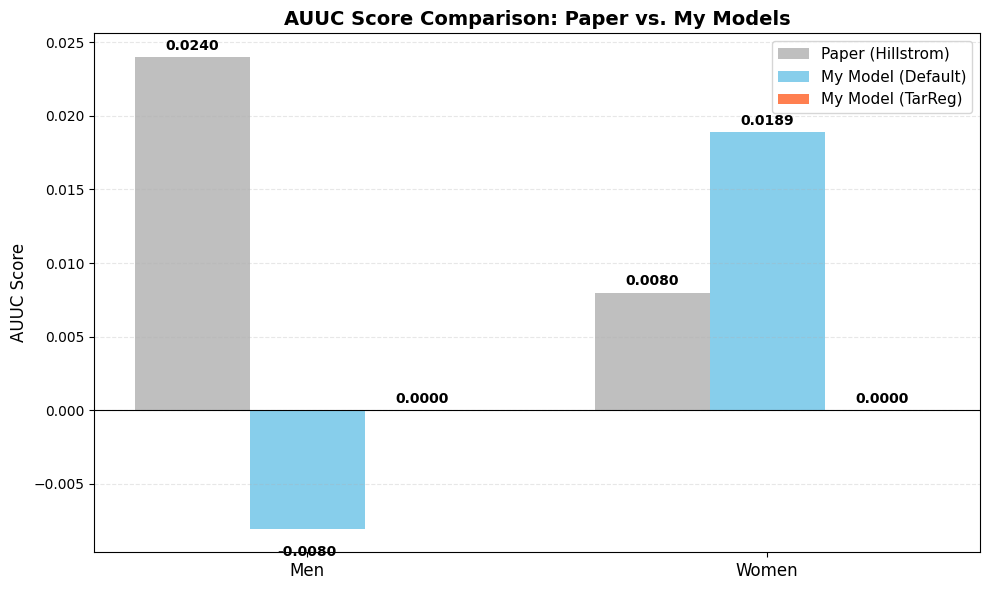

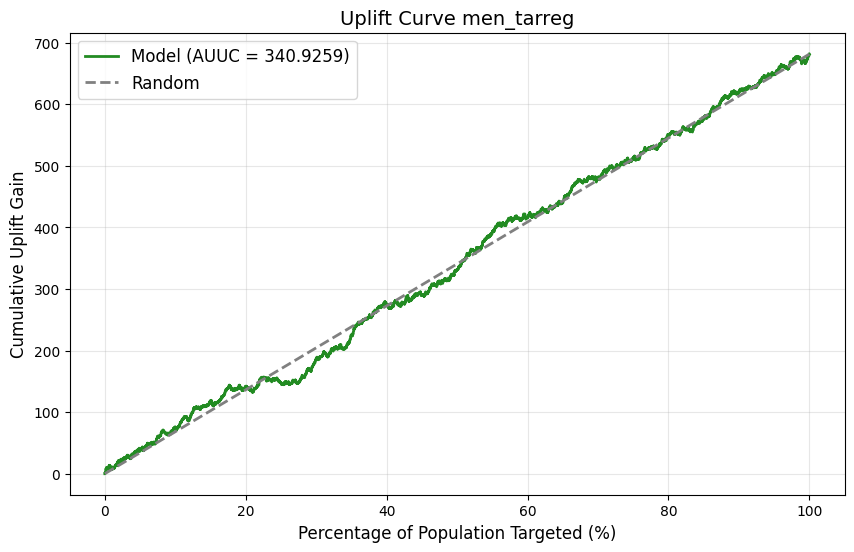

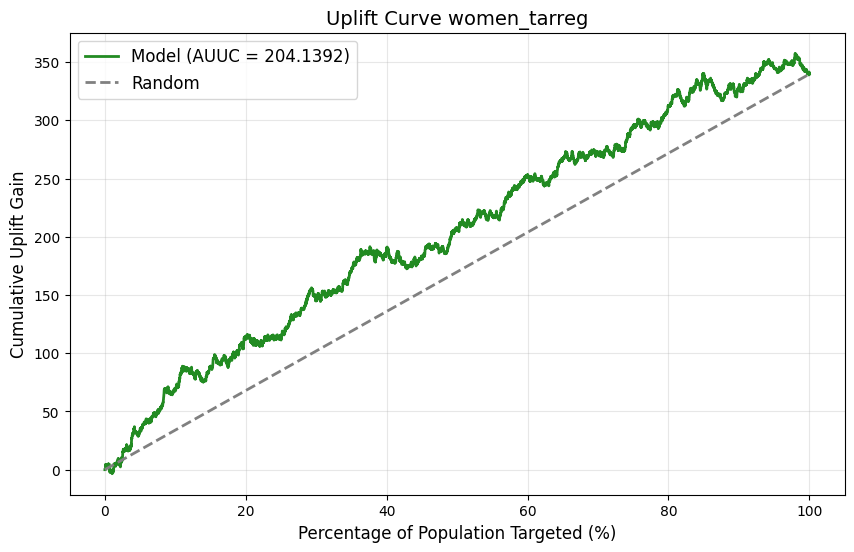

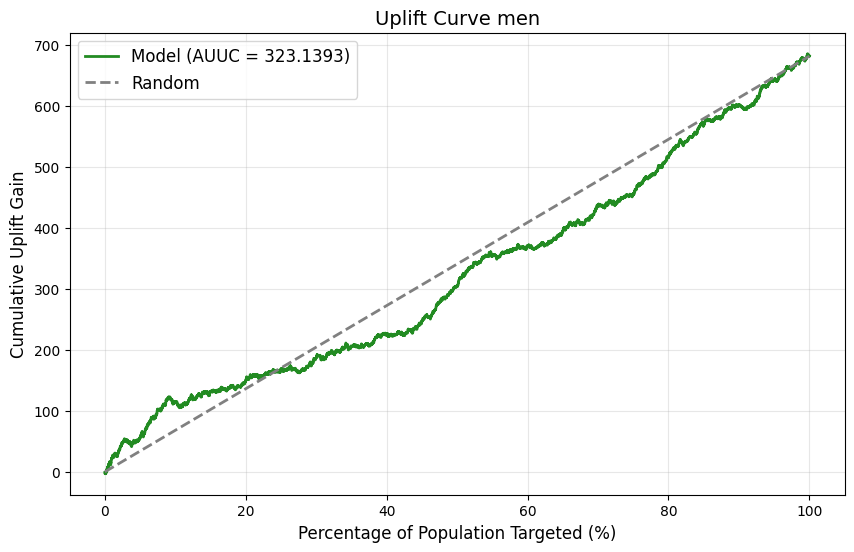

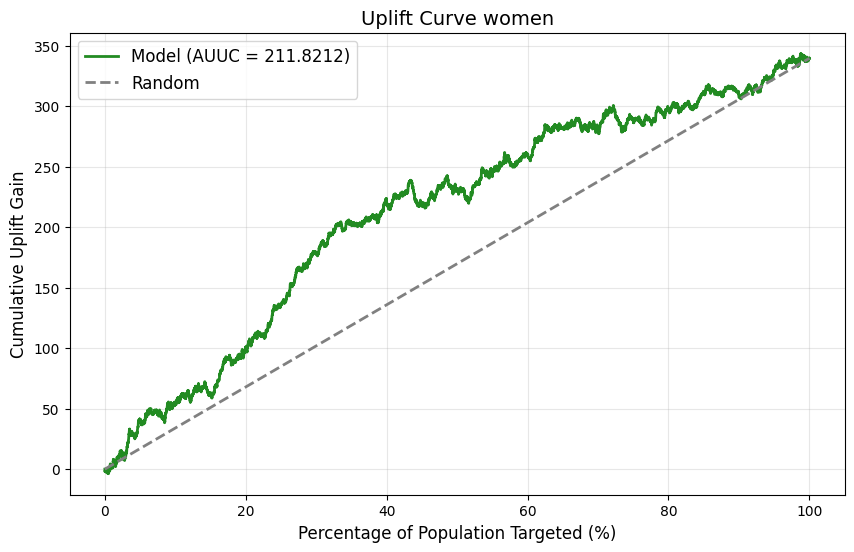

211.82122391946584

In [22]:
paper_metrics = [0.0240, 0.0080] # [Men, Women]
my_default_metrics = [
    auuc_men,   # Men
    auuc_women  # Women
]

# Gom kết quả từ biến toàn cục của bạn (Model TarReg)
my_tarreg_metrics = [
    auuc_men_tarreg,   # Men
    auuc_women_tarreg  # Women
]

# 2. Gọi hàm vẽ AUUC
plot_comparison_with_paper(
    paper_scores=paper_metrics,
    default_scores=my_default_metrics,
    tarreg_scores=my_tarreg_metrics,
    metric_name="AUUC"
)

plot_uplift_curve(y_men_test, uplift_scores_men_tarreg, t_men_test, title="Uplift Curve men_tarreg")
plot_uplift_curve(y_women_test, uplift_scores_women_tarreg, t_women_test, title="Uplift Curve women_tarreg")
plot_uplift_curve(y_men_test, uplift_scores_men, t_men_test, title="Uplift Curve men")
plot_uplift_curve(y_women_test, uplift_scores_women, t_women_test, title="Uplift Curve women")

# Load model

In [23]:
# dragonnet_model_men = Dragonnet(input_dim=men_data_np.shape[1]
#                             epochs=500,
#                             device=device
# )
# dragonnet_model_men.model.load_state_dict(torch.load(f"{DEFAULT_LOSS_PATH}/dragonnet_default_loss_men.pth", weights_only=True, map_location=device))

# dragonnet_model_women = Dragonnet(input_dim=women_data_np.shape[1]
#                             epochs=200,
#                             device=device
# )
# dragonnet_model_women.model.load_state_dict(torch.load(f"{DEFAULT_LOSS_PATH}/dragonnet_default_loss_women.pth", weights_only=True, map_location=device))

# dragonnet_model_men_tarreg = Dragonnet(input_dim=men_data_np.shape[1]
#                             epochs=200,
#                             device=device,
#                             loss_type="tarreg"
# )
# dragonnet_model_men_tarreg.model.load_state_dict(torch.load(f"{TARREG_LOSS_PATH}/dragonnet_tarreg_loss_men.pth", weights_only=True, map_location=device))

# dragonnet_model_women_tarreg = Dragonnet(input_dim=women_data_np.shape[1]
#                             epochs=500,
#                             device=device,
#                             loss_type="tarreg"
# )
# dragonnet_model_women_tarreg.model.load_state_dict(torch.load(f"{TARREG_LOSS_PATH}/dragonnet_tarreg_loss_women.pth", weights_only=True, map_location=device))

In [24]:
torch.save(dragonnet_model_women.model.state_dict(), f"./dragonnet_default_loss/women_default_loss-{model_save_charm}.pth")
torch.save(dragonnet_model_men.model.state_dict(), f"./dragonnet_default_loss/men_default_loss-{model_save_charm}.pth")
torch.save(dragonnet_model_women_tarreg.model.state_dict(), f"./dragonnet_tarreg_loss/women_tarreg_loss-{model_save_charm}.pth")
torch.save(dragonnet_model_men_tarreg.model.state_dict(), f"./dragonnet_tarreg_loss/men_tarreg_loss-{model_save_charm}.pth")

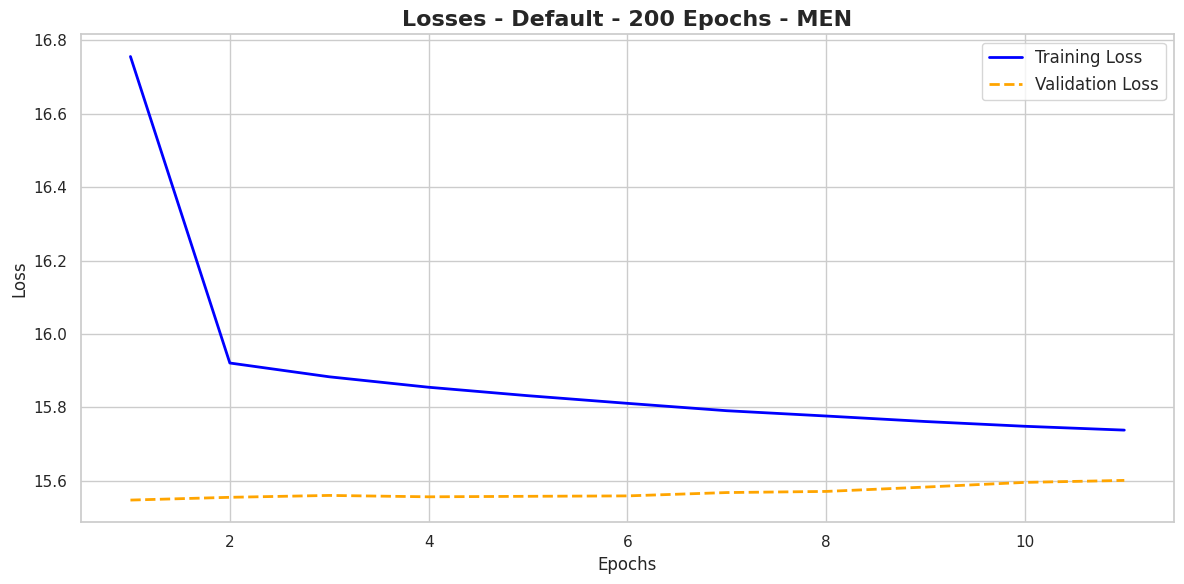

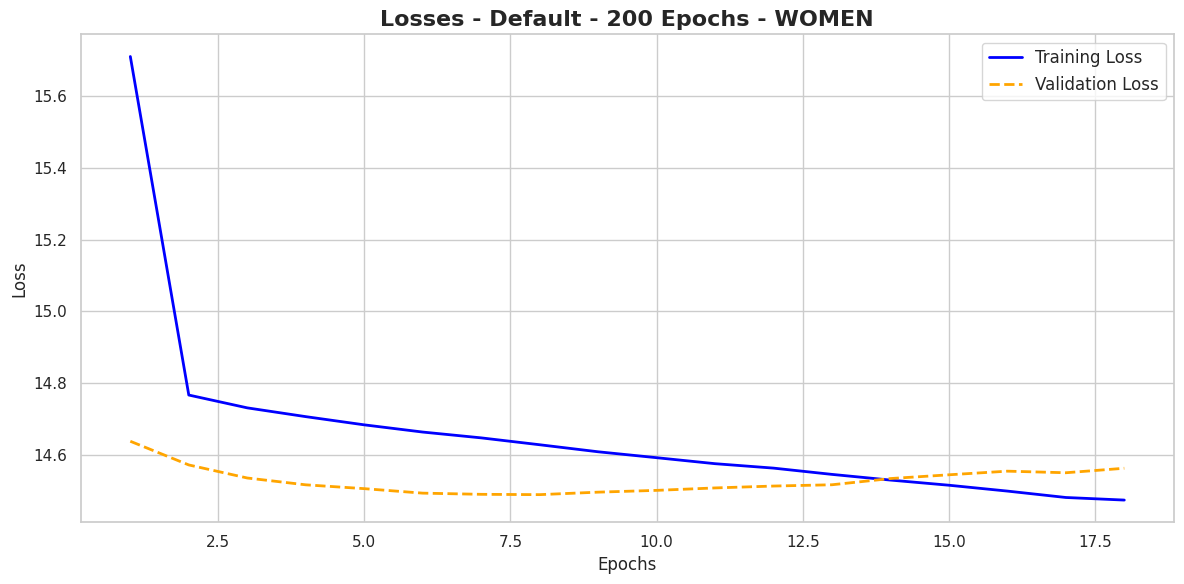

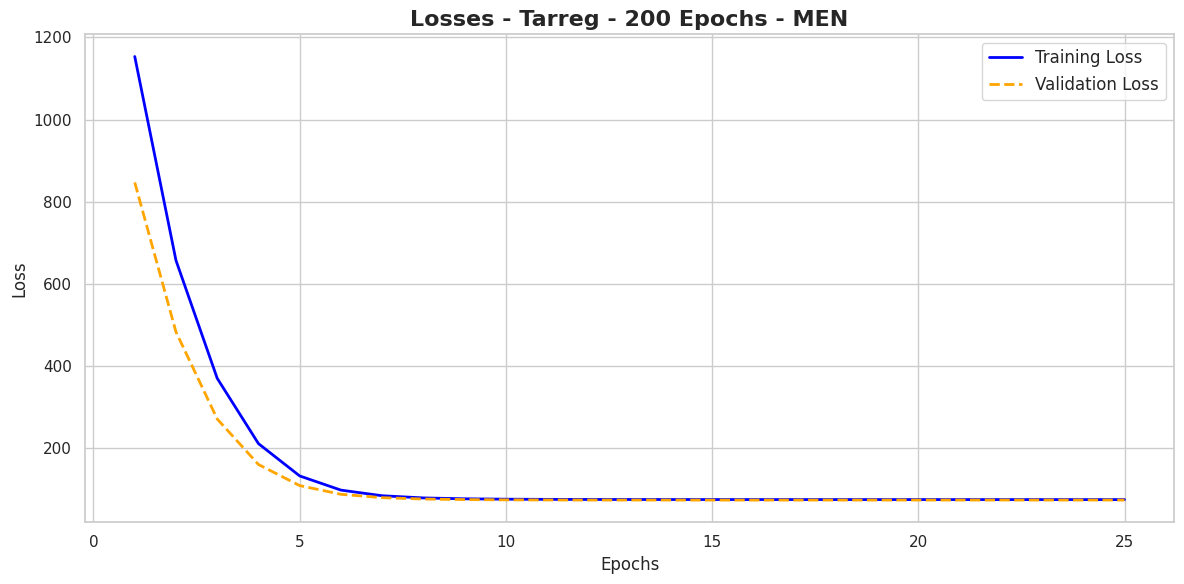

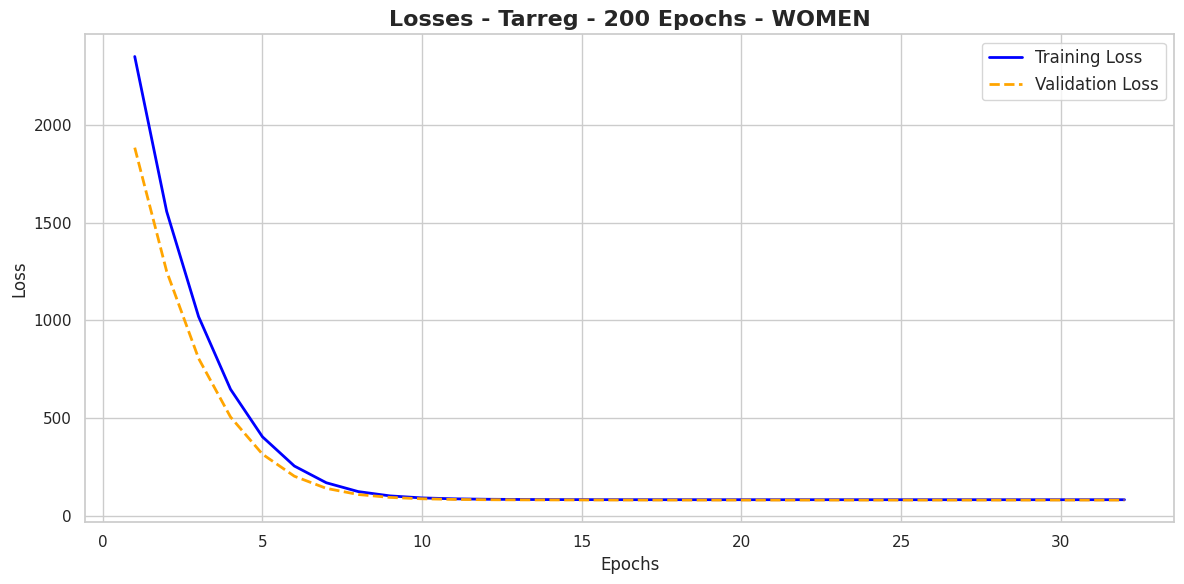

In [25]:
t_losses_men_default = dragonnet_model_men.train_losses
v_losses_men_default = dragonnet_model_men.valid_losses
t_losses_women_default = dragonnet_model_women.train_losses
v_losses_women_default = dragonnet_model_women.valid_losses

t_losses_men_tarreg = dragonnet_model_men_tarreg.train_losses
v_losses_men_tarreg = dragonnet_model_men_tarreg.valid_losses
t_losses_women_tarreg = dragonnet_model_women_tarreg.train_losses
v_losses_women_tarreg = dragonnet_model_women_tarreg.valid_losses

plot_learning_curve(t_losses_men_default, v_losses_men_default, title="Losses - Default - 200 Epochs - MEN")
plot_learning_curve(t_losses_women_default, v_losses_women_default, title="Losses - Default - 200 Epochs - WOMEN")
plot_learning_curve(t_losses_men_tarreg, v_losses_men_tarreg, title="Losses - Tarreg - 200 Epochs - MEN")
plot_learning_curve(t_losses_women_tarreg, v_losses_women_tarreg, title="Losses - Tarreg - 200 Epochs - WOMEN")

# Synthethis data

In [26]:
from causalml.dataset import make_uplift_classification

# Define the treatment names based on the 6 treatments mentioned in the paper
treatment_names = ['treatment_1', 'treatment_2', 'treatment_3', 'treatment_4', 'treatment_5', 'treatment_6']

# Map the provided lists to dictionaries as required by the function
# Note: delta_uplift_increase_dict has only 5 values in the source text;
# you may need to adjust or add a value for the 6th treatment.
delta_uplift_increase = {
    'treatment_1': 0.05, 'treatment_2': 0.1, 'treatment_3': 0.12,
    'treatment_4': 0.17, 'treatment_5': 0.2, 'treatment_6': 0.2 # Assuming 0.2 for the 6th based on pattern or requiring adjustment
}

delta_uplift_decrease = {
    'treatment_1': 0.01, 'treatment_2': 0.02, 'treatment_3': 0.03,
    'treatment_4': 0.05, 'treatment_5': 0.06, 'treatment_6': 0.07
}
n_uplift_increase_mix_informative = [1, 2, 3, 4, 5, 6]
n_uplift_decrease_mix_informative = [1, 1, 1, 1, 1, 1]

# Generate the data
df, x_names = make_uplift_classification(
    n_samples=10000 * 7, # Adjust total samples to account for control + 6 treatments
    treatment_name=treatment_names,
    n_classification_features=100,
    n_classification_informative=20,
    n_classification_redundant=10,
    n_classification_repeated=10,
    positive_class_proportion=0.2,
    delta_uplift_increase_dict=delta_uplift_increase,
    delta_uplift_decrease_dict=delta_uplift_decrease,
    n_uplift_increase_mix_informative_dict={t: v for t, v in zip(treatment_names, n_uplift_increase_mix_informative)},
    n_uplift_decrease_mix_informative_dict={t: v for t, v in zip(treatment_names, n_uplift_decrease_mix_informative)},
    random_seed=42
)

Failed to import duecredit due to No module named 'duecredit'


In [27]:
# 1. Extract Features (X)
# Select all columns that start with 'x' (e.g., x1_informative, x100_irrelevant)
# feature_cols = [col for col in df.columns if col.startswith('x')]
X = df[x_names].values

# 2. Extract Outcome (Y)
# ERROR FIX: The dataframe column is named 'conversion', not 'y'
Y = df['conversion'].values

# 3. Format Treatment (T)
# Map the string labels in 'treatment_group_key' to integers
treatment_map = {
    'control': 0,
    'treatment_1': 1,
    'treatment_2': 2,
    'treatment_3': 3,
    'treatment_4': 4,
    'treatment_5': 5,
    'treatment_6': 6
}
T = df['treatment_group_key'].map(treatment_map).values

# Verify shapes
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"T shape: {T.shape}")

X shape: (420000, 100)
Y shape: (420000,)
T shape: (420000,)


In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# You might need to install scikit-uplift if you haven't: pip install scikit-uplift
from sklift.metrics import uplift_auc_score

def get_metrics_safe(y_true, uplift_pred, treatment_true, true_effect=None):
    """
    Calculates AUUC and MSE, handling cases where a fold is degenerate
    (e.g., missing one treatment group).
    """
    # 1. Try to calculate AUUC
    try:
        # This will raise ValueError if treatment_true has only 0s or only 1s
        auuc = uplift_auc_score(y_true, uplift_pred, treatment_true)
    except ValueError:
        # Fallback: If the fold is bad, return NaN or 0.0
        # Returning NaN is often better so you can filter it out of the mean later
        auuc = float('nan')

    # 2. Calculate MSE (accuracy metric)
    mse = mean_squared_error(true_effect, uplift_pred)

    return auuc, mse

In [29]:
# Initialize dictionaries to store results
results_auuc = {}
results_mse = {}

# Define the 6 treatments
treatments = ['treatment_1', 'treatment_2', 'treatment_3', 'treatment_4', 'treatment_5', 'treatment_6']

# K-Fold for Cross-Validation (Paper uses 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"{'Treatment':<15} | {'AUUC (Mean ± Std)':<20} | {'MSE (Mean ± Std)':<20}")
print("-" * 60)

for t_name in treatments:
    # --- A. Data Preparation for Binary Task ---
    # Filter data: Keep only 'control' and current 'treatment_i'
    mask = df['treatment_group_key'].isin(['control', t_name])
    df_binary = df[mask].copy()

    # Extract arrays
    X_sub = df_binary[x_names].values
    Y_sub = df_binary['conversion'].values  # Binary Outcome
    # Create binary treatment flag: 1 if treatment_i, 0 if control
    T_sub = (df_binary['treatment_group_key'] == t_name).astype(int).values
    # Get True Effect for MSE calculation (ensure this column exists from generation step)
    # Note: synthetic data usually provides the true effect for the specific treatment vs control
    True_Effect_sub = df_binary['treatment_effect'].values

    # --- B. Cross-Validation Loop ---
    fold_auucs = []
    fold_mses = []

    for train_idx, test_idx in kf.split(X_sub):
        # Split data
        X_train, X_test = X_sub[train_idx], X_sub[test_idx]
        Y_train, Y_test = Y_sub[train_idx], Y_sub[test_idx]
        T_train, T_test = T_sub[train_idx], T_sub[test_idx]
        True_Effect_test = True_Effect_sub[test_idx]

        # --- C. Train & Predict (YOUR MODEL HERE) ---
        # 1. Initialize your DragonNet model
        # Note: Ensure your model is reset/re-initialized for every fold!
        dragonnet_model_synthesis = Dragonnet(input_dim=X_train.shape[1],
                            epochs=50,
                            device=device,
                            loss_type="tarreg"
            )

        # 2. Fit the model
        dragonnet_model_synthesis.fit(X_train, Y_train, T_train)

        # 3. Predict Uplift
        y0_pred_synthesis, y1_pred_synthesis, t_pred_synthesis, eps_synthesis = dragonnet_model_synthesis.predict(X_test)

        uplift_pred = y1_pred_synthesis.flatten() - y0_pred_synthesis.flatten()

        # --- D. Calculate Metrics ---
        mse = np.mean((True_Effect_test - uplift_pred)**2)

        # Tính AUUC
        try:
            from sklift.metrics import uplift_auc_score
            auuc = uplift_auc_score(y_true=Y_test, uplift=uplift_pred, treatment=W_test)
        except Exception as e:
            auuc = np.nan # Gán nan nếu lỗi (ví dụ fold không đủ class)

        fold_auucs.append(auuc)
        fold_mses.append(mse)

    # Use np.nanmean to ignore any folds that failed (returned nan)
    mean_auuc = np.nanmean(fold_auucs)
    std_auuc = np.nanstd(fold_auucs)

    mean_mse = np.nanmean(fold_mses) # MSE usually doesn't fail, but safe to keep consistent
    std_mse = np.nanstd(fold_mses)
    # --- E. Aggregate Results for this Treatment ---
    results_auuc[t_name] = f"{np.mean(fold_auucs):.3f} ± {np.std(fold_auucs):.4f}"
    results_mse[t_name]  = f"{np.mean(fold_mses):.3f} ± {np.std(fold_mses):.4f}"

    print(f"{t_name:<15} | {results_auuc[t_name]:<20} | {results_mse[t_name]:<20}")
    print(f"{f'AUUC ({mean_mse:.4f} ± {std_auuc})':<20} | {f'MSE ({mean_mse:.4f} ± {std_mse})':<20}")

# --- F. Final Table Generation ---

# 1. Create a dictionary to hold the data for the final table
# We map the treatment names to column numbers '1', '2', etc.
table_data = {
    'Metric': ['AUUC', 'MSE']
}

for i, t_name in enumerate(treatments, 1):
    col_num = str(i)  # Column header: '1', '2', ... '6'

    # Retrieve the stored "Mean ± Std" strings
    auuc_val = results_auuc.get(t_name, "N/A")
    mse_val = results_mse.get(t_name, "N/A")

    # Add to the column data
    table_data[col_num] = [auuc_val, mse_val]

# 2. Convert to DataFrame and formatting
final_df = pd.DataFrame(table_data)
final_df.set_index('Metric', inplace=True)

# 3. Display the Final Results
print("\n" + "="*50)
print("FINAL RESULTS (DragonNet on 6-Treatment Synthetic Data)")
print("="*50)
print(final_df)

# Optional: If you want to see them as separate tables like the paper
print("\n--- Table 3: AUUC Scores ---")
print(final_df.loc[['AUUC']])

print("\n--- Table 4: MSE Scores ---")
print(final_df.loc[['MSE']])

Treatment       | AUUC (Mean ± Std)    | MSE (Mean ± Std)    
------------------------------------------------------------
Using device: cuda:0
epoch: 0--------- train_loss: 97.2238
epoch: 1--------- train_loss: 50.2547
epoch: 2--------- train_loss: 46.8493
epoch: 3--------- train_loss: 47.0873
epoch: 4--------- train_loss: 35.0436
epoch: 5--------- train_loss: 3.8978
epoch: 6--------- train_loss: 2.6199
epoch: 7--------- train_loss: 2.2321
epoch: 8--------- train_loss: 2.0877
epoch: 9--------- train_loss: 1.9975
epoch: 10--------- train_loss: 1.8040
epoch: 11--------- train_loss: 1.7745
epoch: 12--------- train_loss: 1.6945
epoch: 13--------- train_loss: 1.7074
epoch: 14--------- train_loss: 1.6460
epoch: 15--------- train_loss: 1.6338
epoch: 16--------- train_loss: 1.6389
epoch: 17--------- train_loss: 1.5670
epoch: 18--------- train_loss: 1.6270
epoch: 19--------- train_loss: 1.5808
epoch: 20--------- train_loss: 1.5438
epoch: 21--------- train_loss: 1.6307
epoch: 22--------- train_